## Solving morphogen diffusion equation with multiple fates 

The below functions `morphogen_two_fates` and `morphogen_two_ratios` are modified versions of the `morphogen` and `morphogen_ratio` functions, respectively, that incorporate a third cell fate to the model. Please refer to the python file Morphogen_functions_1_of_2.ipynb for the latter functions. 

In [ ]:
# Libraries 
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp


#Parameters 

L = 100 #Total distance
n= 200 #number of discrete values of L
dx = L/n
C0 = 0 #Initial value of C (concentration of morphgen)
D = 20 #diffusion coefficient 
dt =  round((dx)**2/(2.1*D),4)#value of each timepoint
s = 1
#production rate
k=0.1 # degradation rate
t_final = 10/k #Total time
x = np.linspace(start = 0, stop = L, num = n) #numpy array for representing the space axis 
C = np.ones(n)*C0 # numpy array of the initial value of C with a size n
dCdt = np.ones(n)*C0 #empty array to fill 
t = np.arange(0, t_final, dt) #numpy array to for the time axis


# The following rule should be followed when choosing dt or else the equation becomes unstable
# dt <= (dx)**2/(2*D)

# Check that the rule applies 

rule = (dx)**2/(2*D)
if dt > rule:
    print('dt is ', dt, 'it should be smaller than ', round(rule, 4), '.')
else: 
    print('dt value = ', dt, ' is acceptable')





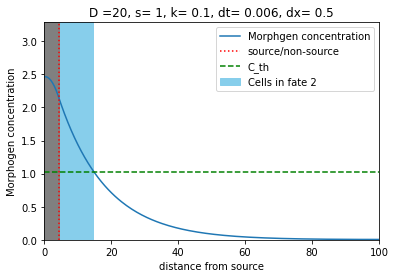

1.0240917193291996


In [47]:
#Solve Diffusion equation
for j in range(1, len(t)):
    plt.clf()
    for i in range(1, n-1):
        if i < 0.05*n -1: # percentage of tissue that is a source
            f = 1 #f is the constant multiplied by s to identify source from non-source. 
        else:
            f = 0
        dCdt[i] = D*(C[i+1]- 2*C[i] + C[i-1])/(dx**2) - k*C[i] + s*f
    dCdt[0] = dCdt[1]
    dCdt[n-1] = dCdt[n-2]
    C = C + dCdt*dt
    C_th =C[int(0.05*n)]/2 #Concentration threshold for non-source cells 
    figname = 'D ='+str(D)+', s= ' +str(s)+', k= '+ str(k)+', dt= '+str(round(dt,4))+ ', dx= '+ str(dx)
plt.figure(1)
plt.plot(x, C)
plt.axvline(x = x[int(0.05*n-1)], color = 'r', linestyle = ':') #non-source cell right next to last source cell
plt.axhline(C_th, color = 'green', linestyle= '--')
plt.title(figname)
plt.xlabel('distance from source')
plt.ylabel('Morphogen concentration')
plt.axis([0,L,0, max(C)+max(C/3)])
plt.fill_between(x, y1=0, y2=L, where=C>C_th, color = 'skyblue')
plt.fill_between(x, y1=0, y2=L, where=C>C[int(0.05*n)], color = 'gray')# last cell in source should not be included (?double check?)
plt.legend([ 'Morphgen concentration', 'source/non-source', 'C_th', 'Cells in fate 2'])
plt.show()
print(C_th)



In [48]:
# Define a function with different fates 

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp
from shapely.geometry import LineString




def morphogen_two_fates(D, s, k, L, n, plot = False, C0 = 0, description = False):
    '''
    
    Description:
    
    Function that solves morphogen diffusion equation and returns: 
    
    - the ratio of tissue lenght in fate 2 over the tissue length in fate 2 (fate2/fate1) 
    - the list of morphogen concentrations at the the final time point
    
    Arguments: 
    
    D: Diffusion coefficient. int or float
    s: production rate. int or float
    k: degradation rate. int or float 
    L: Tissue length (mm). int or float
    n: number of increments of L. int or float
    plot: bool specifying if equation should be plotted. Default is False
    C0: initial morphogen concentration. Default is zero
    description: bool specifying if additional information should be printed out in output. Default is False
    
    Notes: 
    
    - dt is an abritrarly increment of time = round((dx)**2/(2.1*D),4)
    - the total time is pre-defined as 100 s
    - the percentage of source cells is pre-defined as 5% of the tissue length
    - The threshold value of C (C_th) beyond which a non-source cell is in fate 2 is 1.024 molecules/um**3 defined as C[int(0.05*n)]/2 when D = 20, s = 1, k = 0.1, L = 100, and n = 200. 
    
    Example: 
    
    output = morphogen_two_fates(D=20, s=1, k=0.1, L=100, n=200, plot=False)
    output[0] returns ratio (float)
    output[1] returns morphgen concentrations at last timepoint (list)
    ----------------------------------------------------------------------------------------------
    '''
    
    dx = L/n
    dt =  round((dx)**2/(2.1*D),4)#value of each timepoint
    t_final = 100 #Total time
    C0=0
    x = np.linspace(start = 0, stop = L, num = n) #numpy array for representing the space axis 
    C = np.ones(n)*C0 # numpy array of the initial value of C with a size n
    dCdt = np.ones(n)*C0 #empty array to fill 
    t = np.arange(0, t_final, dt) #numpy array to for the time axis

    for j in range(1, len(t)):
        for i in range(1, n-1):
            if i < 0.05*n -1: # percentage of tissue that is a source
                f = 1 #f is the constant multiplied by s to identify source from non-source. 
            else:
                f = 0
            dCdt[i] = D*(C[i+1]- 2*C[i] + C[i-1])/(dx**2) - k*C[i] + s*f
        dCdt[0] = dCdt[1]
        dCdt[n-1] = dCdt[n-2]
        C_prev = C #Store the previous morphogen concentration 
        C = C + dCdt*dt
        C_ss = C[0] - C_prev[0] #Find the differenrce between the current morphogen concentration and the previous one at at x = 0 
        if C_ss < 1e-6: # Find out the time when steady state is reached and display 
            steady_state = 'Steady state reached at '+ str(round(j*dt, 3)) + 's of '+str(t_final)+ 's'
            break
    C_th_1 = 0.753
    C_th_2 = 1.024
    C_th_line_1 = [C_th_1]*n #Line that represents C_th_1 (needed because LineString does not take numbers)
    C_th_line_2 = [C_th_2]*n #Line that represents C_th_2 (needed because LineString does not take numbers)
    line = LineString(np.column_stack((x, C )))
    line1 = LineString(np.column_stack((x, C_th_line_1)))
    line2 = LineString(np.column_stack((x, C_th_line_2)))
    intersection_1 = line.intersection(line1)
    intersection_2 = line.intersection(line2)
    #Find coordinates of intersection between two lines
    C_x_1, C_y_1 = intersection_1.xy #for fate 1 
    C_x_2, C_y_2 = intersection_2.xy #for fate 2
    #Find the lenght of non-source tissue and tissue in fate 2(blue)
    len_non_source = x[n-1] -x[int(0.05*n-1)]
    len_fate2 = C_x_1[0] - C_x_2[0]
    len_fate3 = C_x_2[0] - x[int(0.05*n-1)]
    ratio_1 = len_fate2/len_non_source
    ratio_2 = len_fate3/len_non_source
    if plot == True:
        plt.figure(1, figsize=[8, 6])
        figname = 'D ='+str(D)+', s= ' +str(s)+', k= '+ str(k)+', dt= '+str(round(dt,4))+ ', dx= '+ str(dx)
        plt.plot(x, C)
        plt.axvline(x = x[int(0.05*n-1)], color = 'r', linestyle = '--') #non-source cell right next to last source cell
        plt.axhline(C_th_1, color = 'green', linestyle= '--')
        plt.axhline(C_th_2, color = 'green', linestyle= 'dotted')
        plt.title(figname)
        plt.xlabel(r'distance from source [$\mu$m]')
        plt.ylabel(r'Morphogen concentration [molecules/$\mu$m^3]')
        plt.axis([0,L,0, max(C)+max(C/3)])
        plt.fill_between(x, y1=0, y2=L, where=C<C_th_1, color = 'white')
        plt.fill_between(x, y1=0, y2=L, where=C>C_th_1, color = 'skyblue')
        plt.fill_between(x, y1=0, y2=L, where=C>C_th_2, color = 'deepskyblue')
        plt.fill_between(x, y1=0, y2=L, where=C>C[int(0.05*n)], color = 'gray')# last cell in source should not be included (?double check?)
        #plt.plot(*intersection.xy, 'ro', color = 'w')
        plt.legend([ 'Morphgen Concentration', 'Source/Non-source', 'Concentration Threshold 1','Concentration Threshold 2','Cells in Fate 1','Cells in Fate 2', 'Cells in Fate 3','Source Cells'],facecolor = 'whitesmoke' )
        plt.show()
    if description == True:
        print(steady_state)
        print('Concentration threshold 1: ', C_th_1)
        print('Concentration threshold 1: ', C_th_2)
        print("Fate 2 length/ total non-source length: ", round(ratio_1*100, 3), '%', sep = '' )
        print("Fate 3 length/ total non-source length: ", round(ratio_2*100, 3), '%', sep = '' )
        print('-------------------------------------------------------------------------------')
    return [ratio_1, ratio_2, C]


#I must fix the ratios for fates 2 and fate 3. once a cell is in fate 2 it cannot be in fate 3 or vice versa. I have to think about it. 


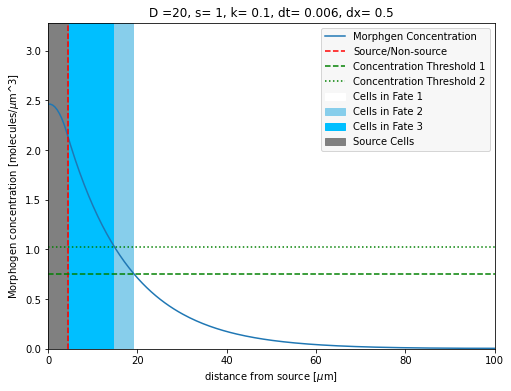

Steady state reached at 59.694s of 100s
Concentration threshold 1:  0.753
Concentration threshold 1:  1.024
Fate 2 length/ total non-source length: 4.569%
Fate 3 length/ total non-source length: 10.827%
-------------------------------------------------------------------------------


In [50]:
output_2 = morphogen_two_fates(D=20, s=1, k=0.1, L=100, n=200, plot=True, description=True)

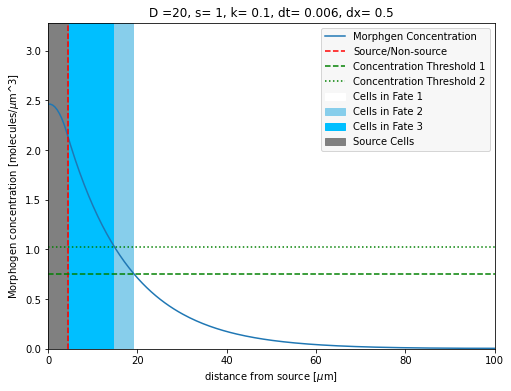

Steady state reached at 59.694s of 100s
Concentration threshold 1:  0.753
Concentration threshold 1:  1.024
Fate 2 length/ total non-source length: 4.569%
Fate 3 length/ total non-source length: 10.827%
-------------------------------------------------------------------------------


In [55]:
output_1 = morphogen_two_fates(D=20, s=1, k=0.1, L=100, n=200, plot=True, description=True)

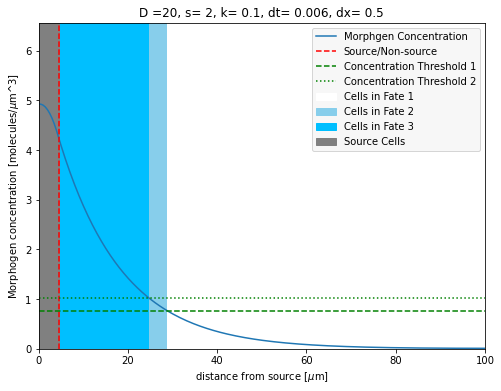

Steady state reached at 66.12s of 100s
Concentration threshold 1:  0.753
Concentration threshold 1:  1.024
Fate 2 length/ total non-source length: 4.57%
Fate 3 length/ total non-source length: 21.147%
-------------------------------------------------------------------------------


In [52]:
output_2 = morphogen_two_fates(D=20, s=2, k=0.1, L=100, n=200, plot=True, description=True)

In [89]:
# Define a function
def morphogen_two_ratios(x, parameter, fate, D=0, s=0, k=0, L=0, n=0, C0=0):
    '''
    Description:
    
    Function that plots the ratio of tissue length in fate 2 or 3 versus 3 parameters. 
    User inputs a list of different values of parameter of interest and fills the constant values of the other parameters and arguments.  
    
    Arguments:
    x: list containing different values for desired parameters
    D: Diffusion coefficient. int or float
    s: production rate. int or float
    k: degradation rate. int or float 
    L: Tissue length (mm). int or float
    n: number of increments of L. int or float
    C0: initial morphogen concentration. Default is zero
    Parameter: Specify the parameter you want to test
                - 'D' for diffusion coefficient 
                - 's' for production rate
                - 'k' for degradation rate
    fate: the cell fate whose proportion is intended to be calculated. Only accepts integer 2 for fate 2 and integer 3 for fate 3. int
    

     
    Notes:
    
    - Default values of all arguments is zero. If they are not specified by the user, the function will show error. 
    - This function depends on the function morphogen_two_fates(). Use help(morphogen_two_fates) for more information. 
    
    Example:
    
    lis = [1, 3, 5, 10, 15, 20]
    morphogen_two_ratios(x = lis, s=0.1,k=0.7, L=100, n=200, parameter = 'D', fate = 2)
    ----------------------------------------------------------------------------------------------


    '''
    ratio_list = []
    for i in x:
        if parameter == 'D':
            out = morphogen_two_fates(D =i, s=s, k=k, L=L, n=n)
            param = 'Diffusion Coefficient'
            unit = r' [$\mu$m/s]'
        if parameter == 's':
            out = morphogen_two_fates(D =D, s=i, k=k, L=L, n=n)
            param = 'Production Rate'
            unit =  r' [molecules/$\mu$m^3.s]'
        if parameter == 'k':
            out = morphogen_two_fates(D =D, s=s, k=i, L=L, n=n)
            param = 'Degradation Rate'
            unit = " [1/s]"
        if fate == 2 or fate ==3:
            ratio_list.append(out[fate - 2])
    x_title = param + unit
    plt.plot(x, ratio_list)
    title = ' Proportion of tissue length in fate '+ str(fate)+ ' versus ' + param
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel('fate length/ total non-source length')

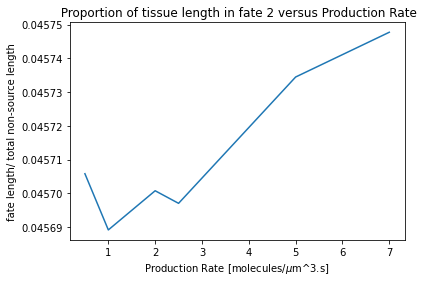

In [90]:
# Varying values of s
lis = [7, 5, 2.5, 2, 1, 0.5]
morphogen_two_ratios(x = lis, D = 20, k=0.1, L=100, n=200, parameter = 's', fate= 2)

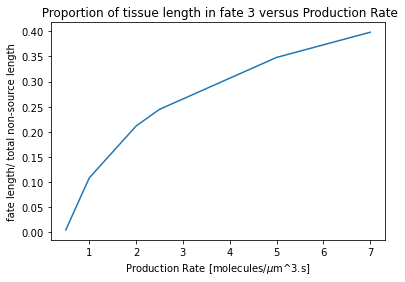

In [91]:
# Varying values of s
lis = [7, 5, 2.5, 2, 1, 0.5]
morphogen_two_ratios(x = lis, D = 20, k=0.1, L=100, n=200, parameter = 's', fate= 3)

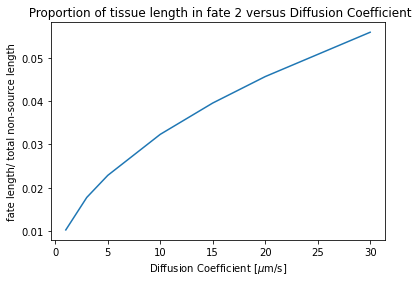

In [92]:
# Varying values of D
lis = [1, 3, 5, 10, 15, 20, 30]
morphogen_two_ratios(x = lis, s=1,k=0.1, L=100, n=200, parameter = 'D', fate =2 )

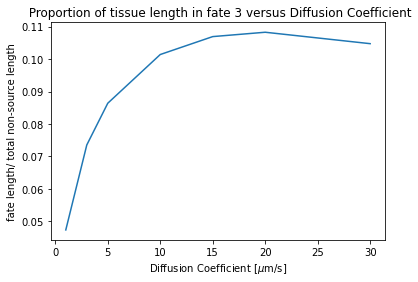

In [93]:
# Varying values of D
lis = [1, 3, 5, 10, 15, 20, 30]
morphogen_two_ratios(x = lis, s=1,k=0.1, L=100, n=200, parameter = 'D', fate =3 )

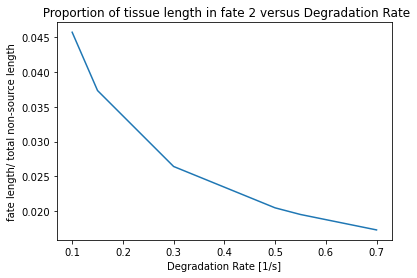

In [94]:
# Varying values of k
lis = [0.1, 0.15, 0.3,0.5,0.55, 0.7]
morphogen_two_ratios(x = lis, D = 20, s=2, L=100, n=200, parameter = 'k', fate = 2)

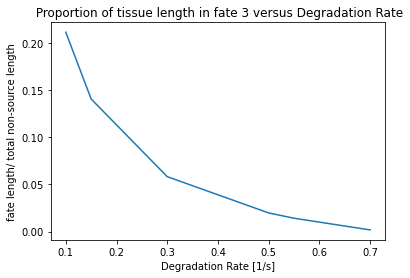

In [95]:
# Varying values of k
lis = [0.1, 0.15, 0.3,0.5,0.55, 0.7]
morphogen_two_ratios(x = lis, D = 20, s=2, L=100, n=200, parameter = 'k', fate = 3)